# Import packages

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm

Used for windows and folds

In [9]:
import sys

In [12]:
sys.path.append("../windowing_and_cv")
sys.path.append("..")

In [13]:
from windowing_and_cv.tscv_sliding import TimeSeriesSplitSliding
from window_generator import WindowGenerator
from sklearn.model_selection import TimeSeriesSplit

# Import data

In [92]:
raw_df = pd.read_csv("../data/feature_selected_data.csv", index_col=0, parse_dates=[0])
raw_df.head()

,VIX,BAA10Y,DGS10,USEPUINDXD,BAMLC0A4CBBB,BAMLC0A1CAAA,BAMLC0A4CBBBEY,BAMLC0A0CM,DFII10,T10YIE,...,Gold_R,Bearish,EMA_5,EMA_10,MOM_5,RSI_5,RSI_10,BOLDOWN_5,ADX_5,ADX_10
2003-01-02,25.39,3.37,4.07,324.67,2.67,1.01,6.17,1.86,2.43,1.64,...,NaN,0.3784,25.390000,25.390000,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-03,24.68,3.39,4.05,357.74,2.64,1.01,6.14,1.85,2.43,1.62,...,0.694165,0.3784,24.964000,24.999500,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-06,24.91,3.38,4.09,166.02,2.61,0.99,6.14,1.82,2.46,1.63,...,0.703615,0.3784,24.938421,24.963522,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-07,25.13,3.39,4.04,180.02,2.58,0.97,6.07,1.81,2.42,1.62,...,0.689230,0.3784,25.018000,25.018369,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-08,25.53,3.35,4.00,204.91,2.57,0.96,6.02,1.80,2.29,1.71,...,0.694221,0.3784,25.214550,25.165244,NaN,NaN,NaN,24.436278,NaN,NaN


Check for Nans

In [64]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   VIX             5217 non-null   float64
 1   BAA10Y          5217 non-null   float64
 2   DGS10           5217 non-null   float64
 3   USEPUINDXD      5217 non-null   float64
 4   BAMLC0A4CBBB    5217 non-null   float64
 5   BAMLC0A1CAAA    5217 non-null   float64
 6   BAMLC0A4CBBBEY  5217 non-null   float64
 7   BAMLC0A0CM      5217 non-null   float64
 8   DFII10          5217 non-null   float64
 9   T10YIE          5217 non-null   float64
 10  DCOILWTICO_R    5216 non-null   float64
 11  Mkt-RF          5217 non-null   float64
 12  ST_Rev          5217 non-null   float64
 13  Gold_R          5216 non-null   float64
 14  Bearish         5217 non-null   float64
 15  EMA_5           5217 non-null   float64
 16  EMA_10          5217 non-null   float64
 17  MOM_5          

Some of the data is returns, thus should drop first day and untransformed data

In [93]:
# Set first day to 1 + first day
df = raw_df.iloc[10:].copy()
del raw_df
try:
    df.drop(columns=["DCOILWTICO", "DTWEXBGS", "Gold"], inplace=True)
except KeyError as e:
    print(e.args)

("['DCOILWTICO', 'DTWEXBGS', 'Gold'] not found in axis",)


## Change to *Business Day* frequency. Should not introduce any NaNs in index, as demonstrated below.
Useful for some models in the `statsmodels` package

In [94]:
(df.asfreq("B") == df).all()

VIX               True
BAA10Y            True
DGS10             True
USEPUINDXD        True
BAMLC0A4CBBB      True
BAMLC0A1CAAA      True
BAMLC0A4CBBBEY    True
BAMLC0A0CM        True
DFII10            True
T10YIE            True
DCOILWTICO_R      True
Mkt-RF            True
ST_Rev            True
Gold_R            True
Bearish           True
EMA_5             True
EMA_10            True
MOM_5             True
RSI_5             True
RSI_10            True
BOLDOWN_5         True
ADX_5             True
ADX_10            True
dtype: bool

In [95]:
df = df.asfreq("B")

# Set up train/test split
In-sample and out-of-sample splits. The validation procedure will be done by cross-validation for the training data

## Determine split by inspecting Vix

If using `train/test`-split, it can be useful to inspect the data and corresponding splits.

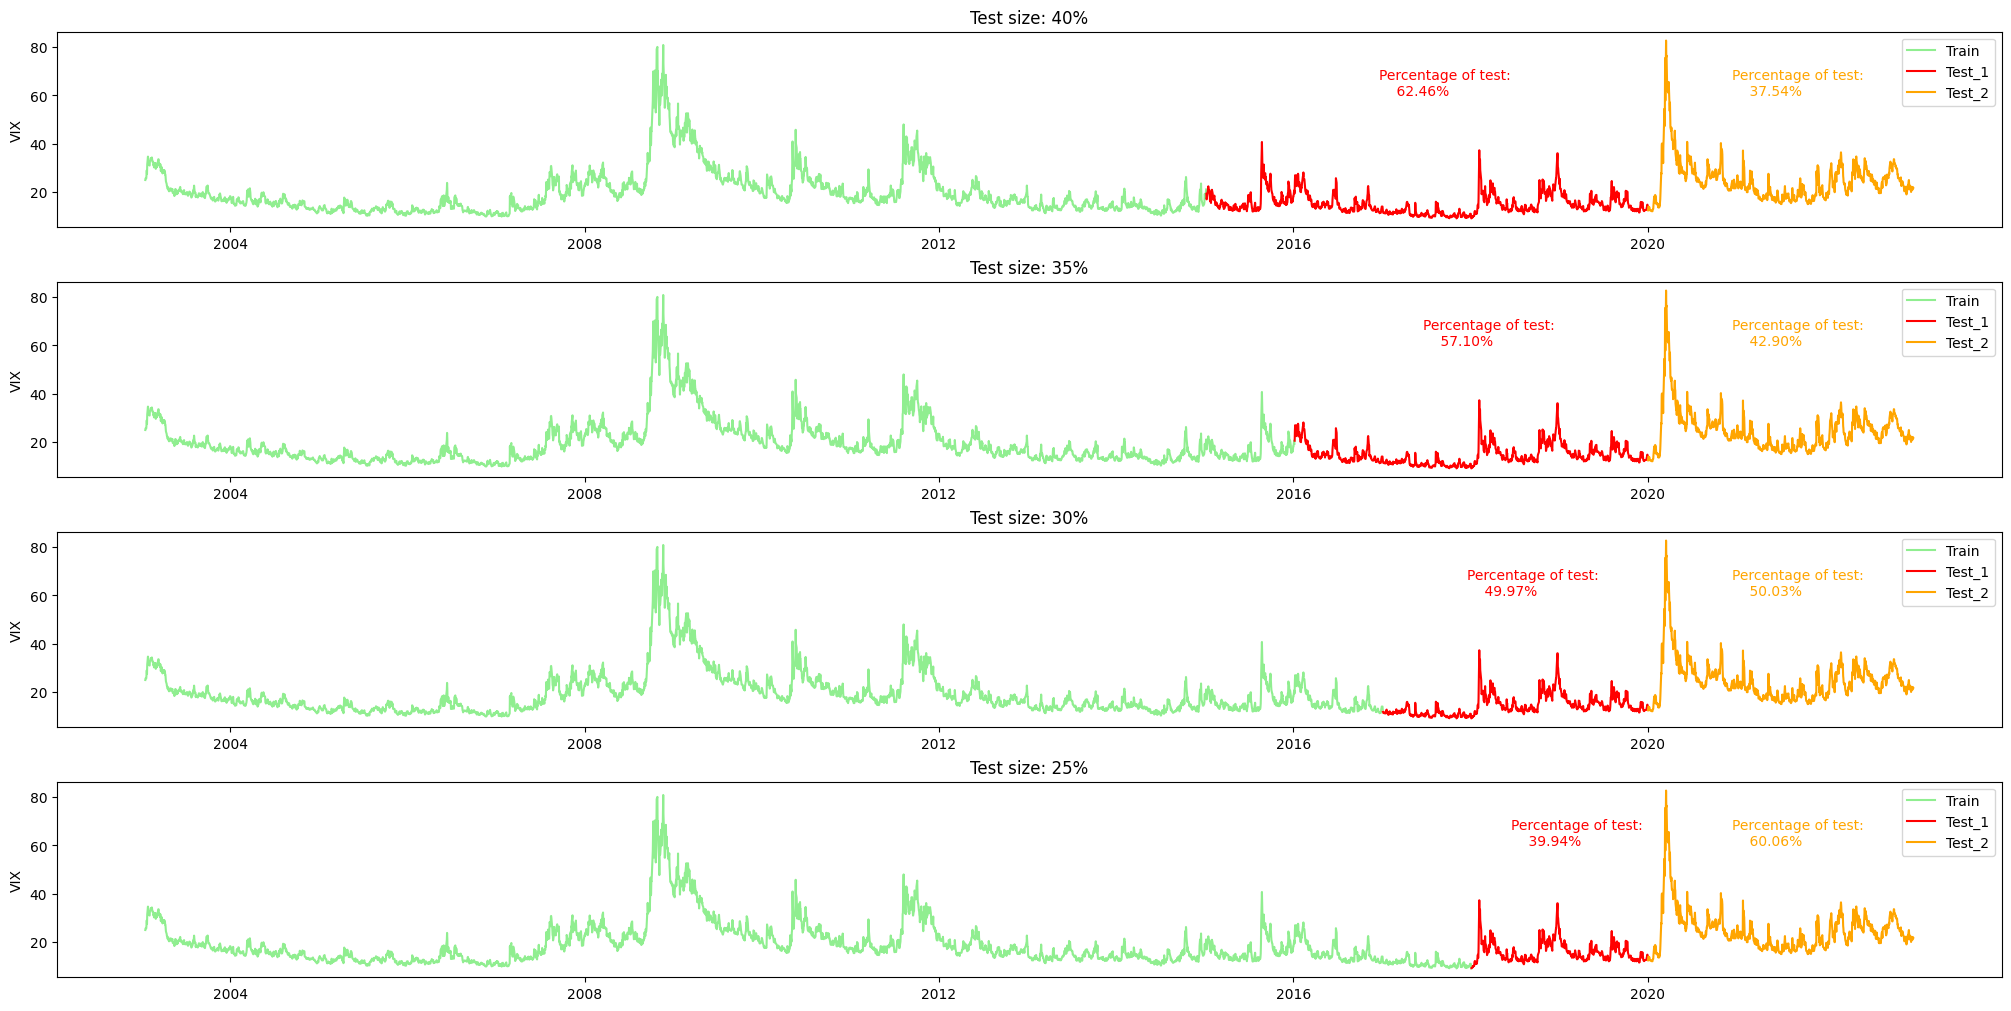

In [99]:
n = len(df)
inds = [0.6, 0.65, 0.7, 0.75]
fig, axs = plt.subplots(len(inds), 1, figsize=(20, 10), constrained_layout=True)
for ax, ind in zip(axs.ravel(), inds):
    # Create copy of frame
    temp = df.VIX.copy().to_frame()
    temp["frame"] = ""
    # Set belonging set, ie, train or test
    train_ind = int(n*ind)
    temp.iloc[:train_ind, 1] = "Train"
    # Split test into pre- and post-covid
    temp.iloc[train_ind:, 1] = "Test_1"
    temp.loc[temp.index > "2020", "frame"] = "Test_2"
    # Compute size of each group
    sizes = temp.loc[temp.frame != "Train"].frame.value_counts(normalize=True)
    size_1 = f"Percentage of test:\n    {sizes['Test_1']:0.2%}"
    size_2 = f"Percentage of test:\n    {sizes['Test_2']:0.2%}"
    # Plot 
    palette = {"Train":"lightgreen", "Validation":"purple", "Test_1":"red", "Test_2":"orange"}
    ax.set_title(f"Test size: {1-ind:.0%}")
    sns.lineplot(temp, x=temp.index, y="VIX", hue="frame", palette=palette, ax=ax)
    ax.legend(loc="upper right")
    # Annotate with each sets corresponding size
    for line in ax.get_lines():
        #print(line.get_data())
        break
    #ax.text(10000, 50, size_1, )
    x_1 = ax.get_lines()[1].get_data()[0].mean() - 200
    x_2 = ax.get_lines()[2].get_data()[0].mean() - 200
    ax.annotate(size_1,
            xy=(x_1, 60), xycoords="data", fontsize=10, color="red")
    ax.annotate(size_2,
            xy=(x_2, 60), xycoords="data", fontsize=10, color="orange")
    del temp

The better split appears to be using a test size of 30%. This allows for sufficient training data size, as well as even split between pre- and post-covid.

## Create split
Using the chosen split, split into train and test data

In [96]:
train_size = 0.7
n = len(df)
train_ind = int(n*train_size)
train_df = df[:train_ind]
test_df = df[train_ind:]

# Folds and windows

## Creating window generator

The number of lags is chosen to be **?**

In [69]:
input_width = 5
window = WindowGenerator(
    input_width=input_width, label_width=1, shift=1, label_columns=['VIX'], 
    train_df=train_df, test_df=test_df)
window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['VIX']

## Converting into arrays

The following function can be used for converting tensorflow `Map Datasets` into `numpy array`

In [70]:
def create_numpy_array_from_window(train, val=None):
    """
    Returns datasets as numpy array in following order:
    train_X, train_y, val_X, val_Y
    """
    # Convert to numpy arrays
    train_X = np.concatenate([x for x, y in train], axis=0)
    train_X = train_X.reshape(len(train_X), -1)
    
    train_y = np.concatenate([y for x, y in train], axis=0)
    train_y = train_y.reshape((-1))

    if val is not None:
        val_X = np.concatenate([x for x, y in val], axis=0)
        val_X = val_X.reshape(len(val_X), -1)
    
        val_y = np.concatenate([y for x, y in val], axis=0)
        val_y = val_y.reshape((-1))
        return train_X, train_y, val_X, val_y
    else:
        return train_X, train_y

Get training data as arrays

In [71]:
x_train, y_train = create_numpy_array_from_window(window.train)
print(x_train.shape)
y_train.shape

(3639, 115)


(3639,)

## Splitting
The following function can be used to split the data. Uses the approach described in `regression_feature_sel.ipynb` for simplified folds creation

In [72]:
def split_data(
    x_train:np.array, y_train:np.array, size=None, 
    n_splits=5, train_splits=3, test_splits=1, 
    convert_to_list=False
):
    """
    Splits the data into folds using the desired proportions.
    The folds are generator objects, thus must use convert_to_list to get as list.
    Specify the size argument to avoid using pre-constructed X and y arrays
    """
    # Create splits 
    if size is not None:
        x_train = np.arange(size)
        y_train = x_train
    n_samples = len(x_train)
    tot_split = n_samples // (n_splits + 1 + train_splits + test_splits - 2)
    m_train = tot_split * train_splits
    m_test = tot_split * test_splits
    tp = TimeSeriesSplit(n_splits=5, max_train_size=m_train, test_size=m_test)
    # Get folds
    folds = tp.split(x_train, y_train)
    if convert_to_list:
        return list(folds)
    return folds

## Visualize folds
Visualize the folds according to the specified proportions

Helper function for splitting and visualizing folds. Using the approach described in `regression_feature_sel.ipynb` for simplified folds creation

In [73]:
def split_and_visualize(
    x_train:np.array, y_train:np.array, df:pd.DataFrame, train_df:pd.DataFrame, 
    n_splits=5, train_splits=3, test_splits=1, plot_all=True, target="VIX"
):
    """
    Visualize folds using the determined splitting regime.
    Use plot_all=True to plot target over entire period
    """
    # Ensure target is in both columns
    if target not in train_df.columns:
        print(target + " is not in the columns of the training dataframe")
        return
    elif target not in df.columns and plot_all:
        print(target + " is not in the overall dataframe")
        return
    
    # Create splits
    folds = split_data(
        x_train=x_train, y_train=y_train, n_splits=n_splits, 
        train_splits=train_splits, test_splits=test_splits,
        
    )
    fig, axs = plt.subplots(5, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
    i = 0
    i_train = 0
    i_test = 0
    for fold, ax in zip(folds, axs.ravel()):
        #if i > 4:
        #    break
        train = train_df.iloc[fold[0]]
        test = train_df.iloc[fold[1]]
        print(f"Train start: {train.index[0].date()}\tTrain end: {train.index[0].date()}\tTrain size: {len(train)}")
        print(f"Test start: {test.index[0].date()}\tTest end: {test.index[-1].date()}\tTest size: {len(test)}")
        sns.lineplot(train[target], color="lightblue", ax=ax, label="Train")
        sns.lineplot(test[target], color="salmon", ax=ax, label="Validation")
        if plot_all:
            m1 = df.index < train.index[0]
            m2 = df.index > test.index[-1]
            sns.lineplot(df.loc[m1, target], color="lightgrey", ax=ax, ls=":")
            sns.lineplot(df.loc[m2, target], color="lightgrey", ax=ax, ls=":")
            ax.set_ylabel(None)
        #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        i_train += len(train)
        if i > 0:
            ax.get_legend().remove()
        i += 1
    fig.text(-0.01, 0.5, target, rotation=90, fontsize=16)
    fig.suptitle("CV Fold Visualization ", fontsize=20);

### 3:1 split(75%)

Train start: 2003-01-27	Train end: 2003-01-27	Train size: 1362
Test start: 2008-04-16	Test end: 2010-01-11	Test size: 454
Train start: 2004-10-22	Train end: 2004-10-22	Train size: 1362
Test start: 2010-01-12	Test end: 2011-10-07	Test size: 454
Train start: 2006-07-20	Train end: 2006-07-20	Train size: 1362
Test start: 2011-10-10	Test end: 2013-07-04	Test size: 454
Train start: 2008-04-16	Train end: 2008-04-16	Train size: 1362
Test start: 2013-07-05	Test end: 2015-04-01	Test size: 454
Train start: 2010-01-12	Train end: 2010-01-12	Train size: 1362
Test start: 2015-04-02	Test end: 2016-12-27	Test size: 454


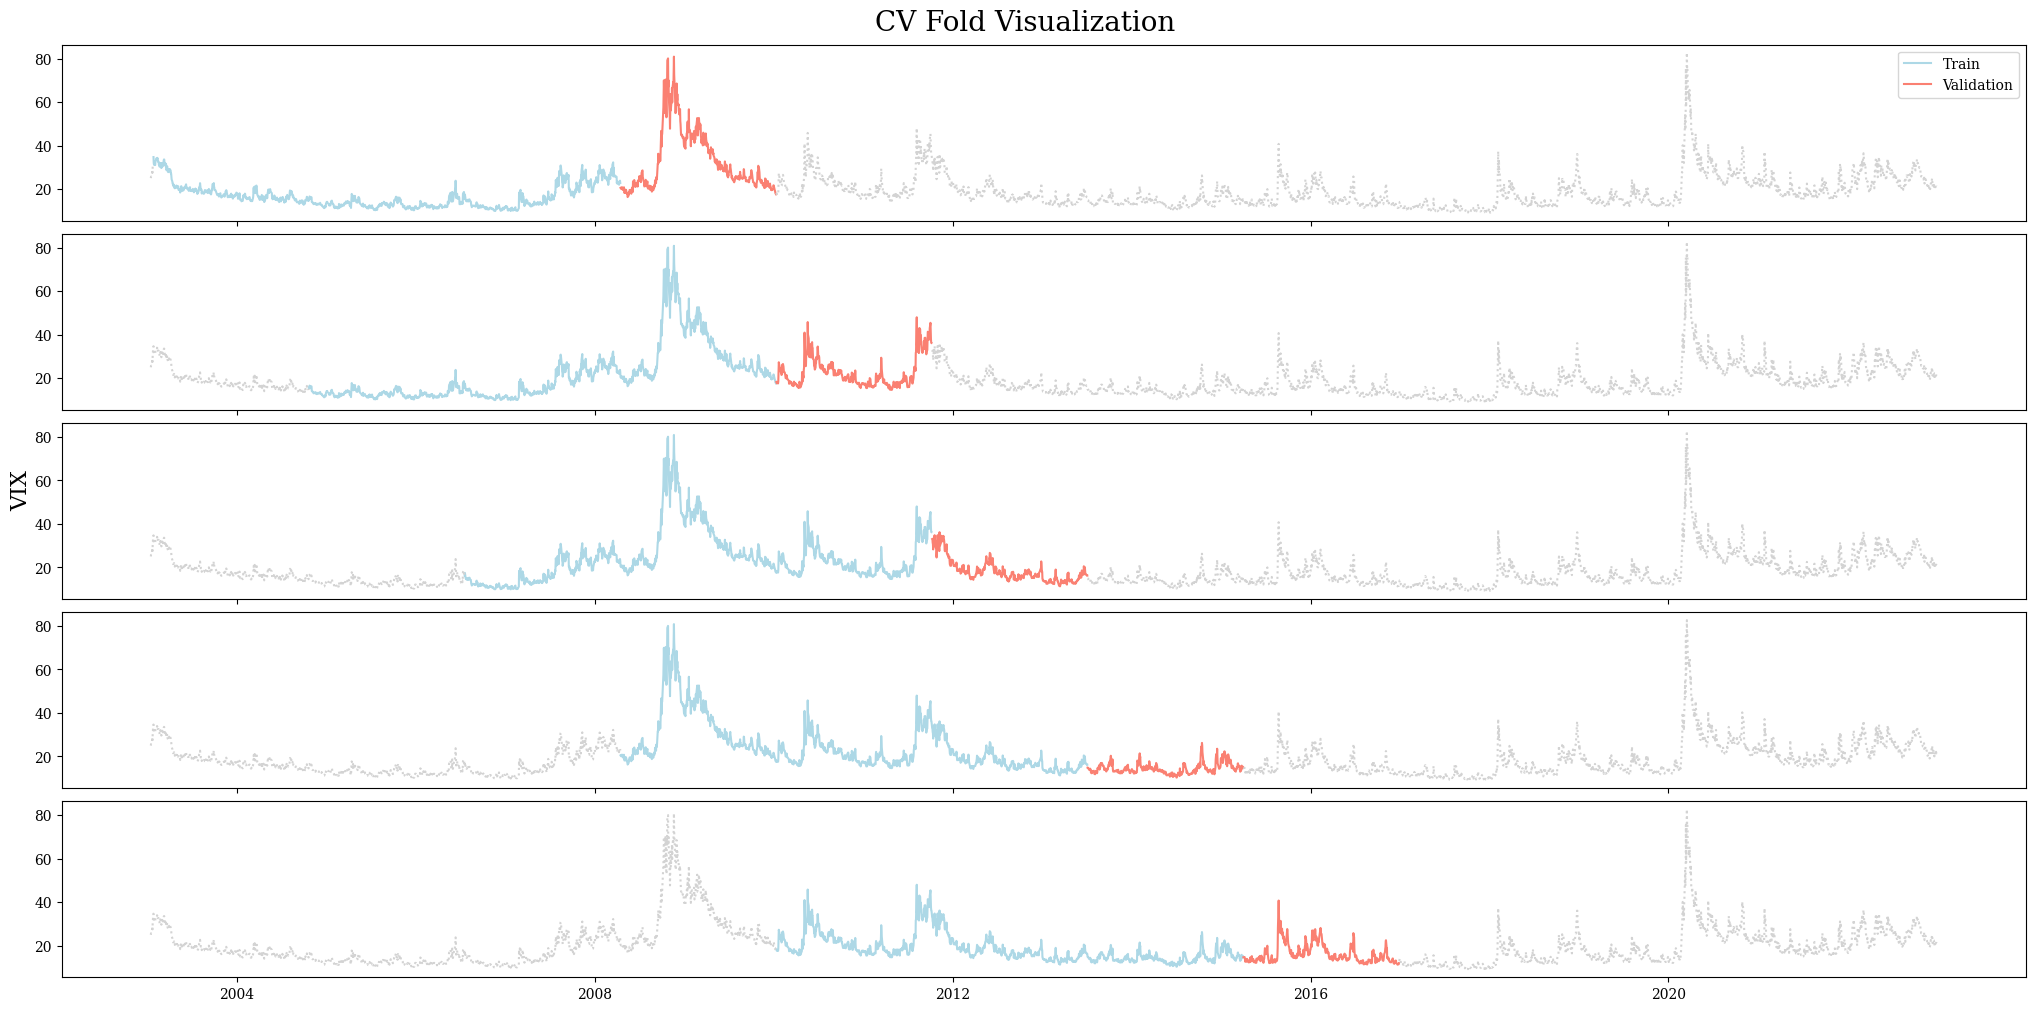

In [74]:
split_and_visualize(
    x_train=x_train, y_train=y_train,
    df=df, train_df=train_df,
    n_splits=5, train_splits=3, test_splits=1, plot_all=True, target="VIX"
)

### 2:1 split (66%)

Train start: 2003-01-24	Train end: 2003-01-24	Train size: 1038
Test start: 2007-01-17	Test end: 2009-01-12	Test size: 519
Train start: 2005-01-20	Train end: 2005-01-20	Train size: 1038
Test start: 2009-01-13	Test end: 2011-01-07	Test size: 519
Train start: 2007-01-17	Train end: 2007-01-17	Train size: 1038
Test start: 2011-01-10	Test end: 2013-01-03	Test size: 519
Train start: 2009-01-13	Train end: 2009-01-13	Train size: 1038
Test start: 2013-01-04	Test end: 2014-12-31	Test size: 519
Train start: 2011-01-10	Train end: 2011-01-10	Train size: 1038
Test start: 2015-01-01	Test end: 2016-12-27	Test size: 519


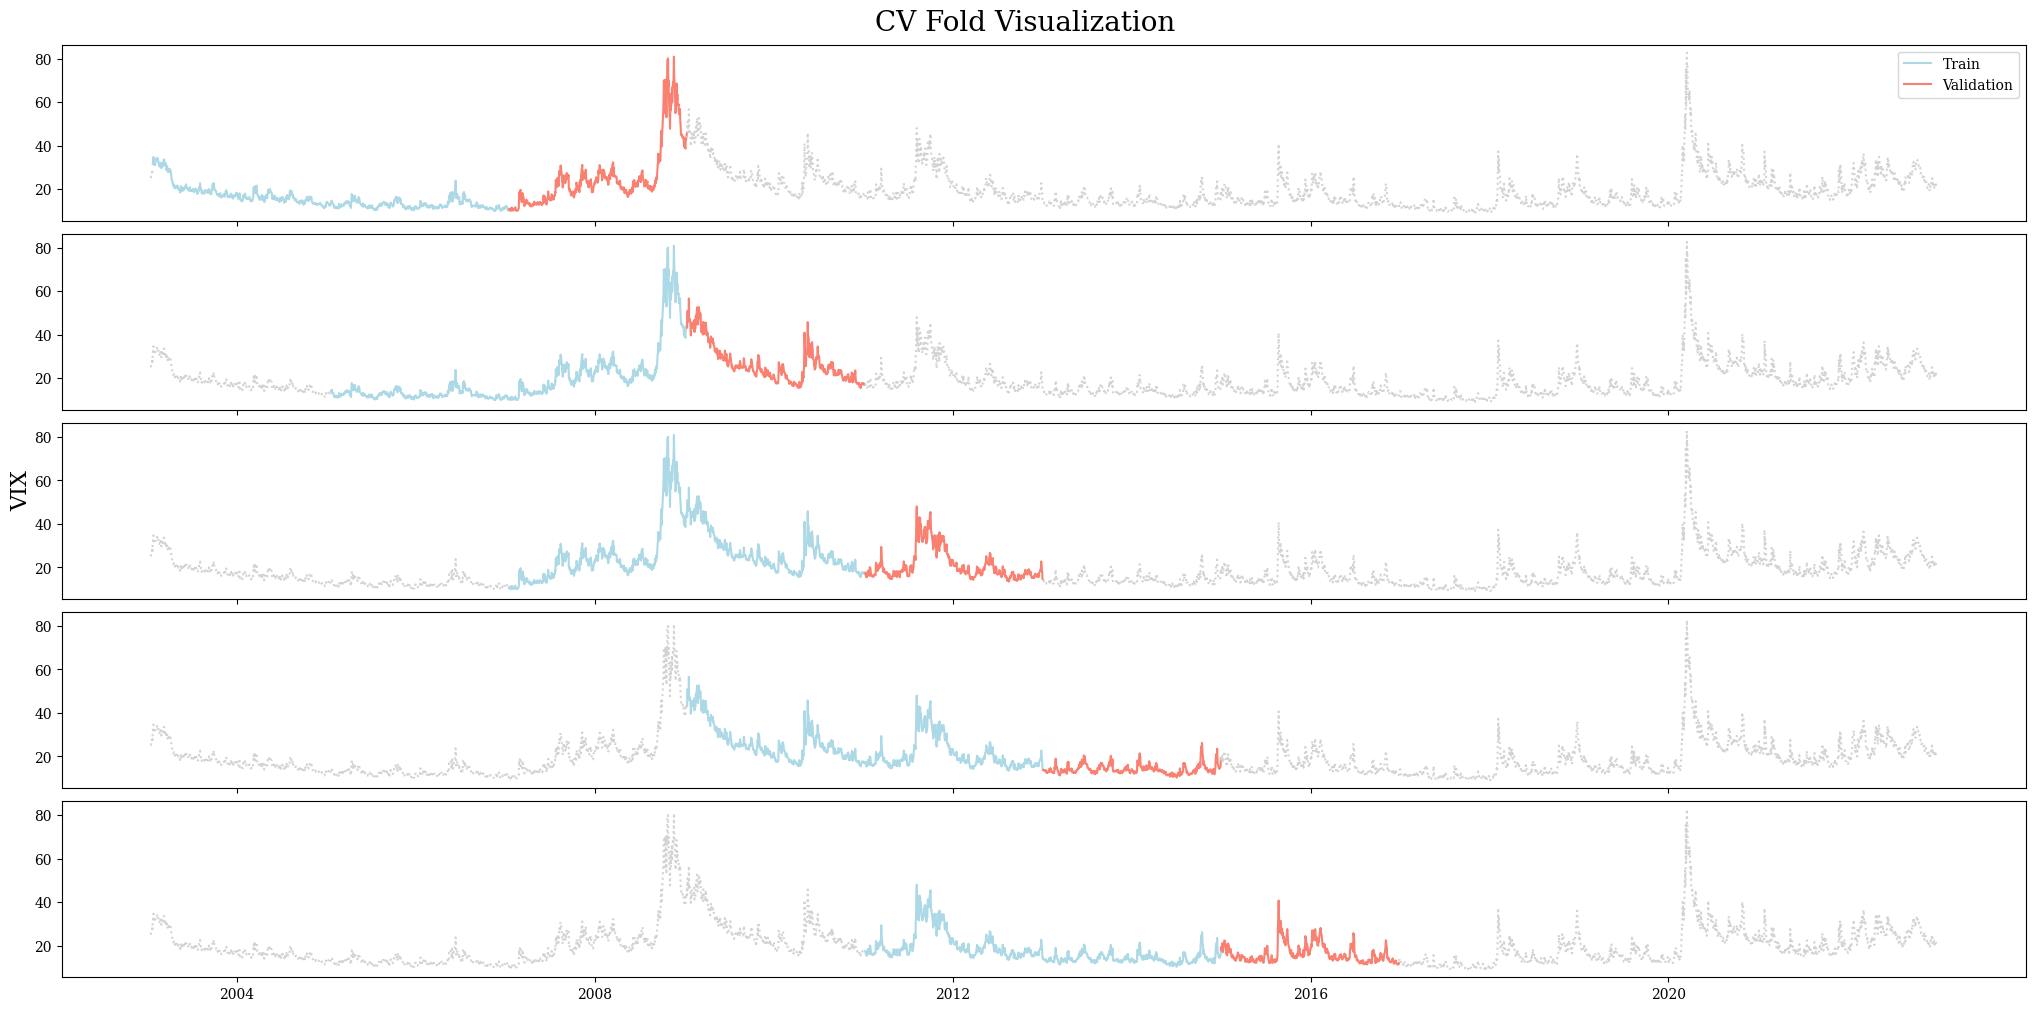

In [177]:
split_and_visualize(
    x_train=x_train, y_train=y_train,
    df=df, train_df=train_df,
    n_splits=5, train_splits=2, test_splits=1, plot_all=True, target="VIX"
)

### 4:1 split (80%)

Train start: 2003-01-21	Train end: 2003-01-21	Train size: 1616
Test start: 2009-04-01	Test end: 2010-10-18	Test size: 404
Train start: 2004-08-09	Train end: 2004-08-09	Train size: 1616
Test start: 2010-10-19	Test end: 2012-05-04	Test size: 404
Train start: 2006-02-24	Train end: 2006-02-24	Train size: 1616
Test start: 2012-05-07	Test end: 2013-11-21	Test size: 404
Train start: 2007-09-13	Train end: 2007-09-13	Train size: 1616
Test start: 2013-11-22	Test end: 2015-06-10	Test size: 404
Train start: 2009-04-01	Train end: 2009-04-01	Train size: 1616
Test start: 2015-06-11	Test end: 2016-12-27	Test size: 404


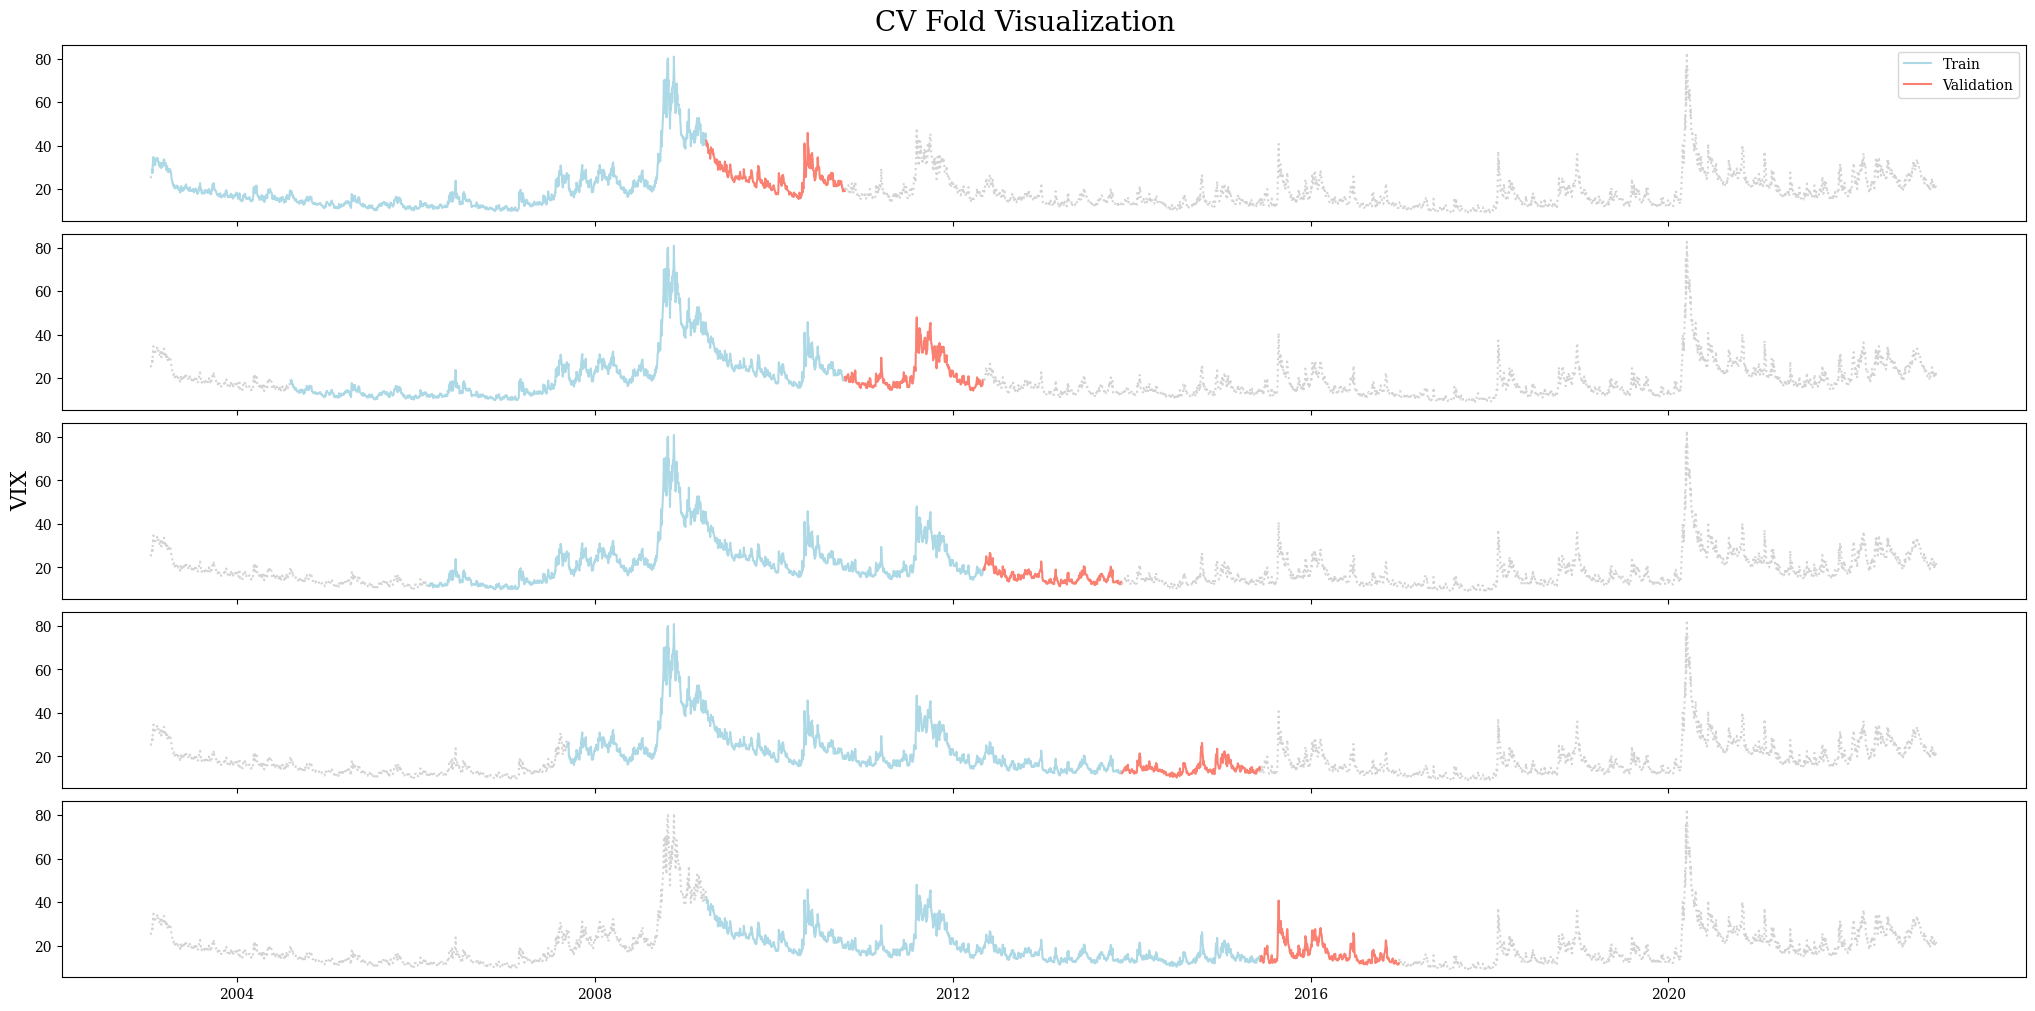

In [178]:
split_and_visualize(
    x_train=x_train, y_train=y_train,
    df=df, train_df=train_df,
    n_splits=5, train_splits=4, test_splits=1, plot_all=True, target="VIX"
)

## Summary 
To summarize, use 3:1 split

### Inspect single column relationship if desired

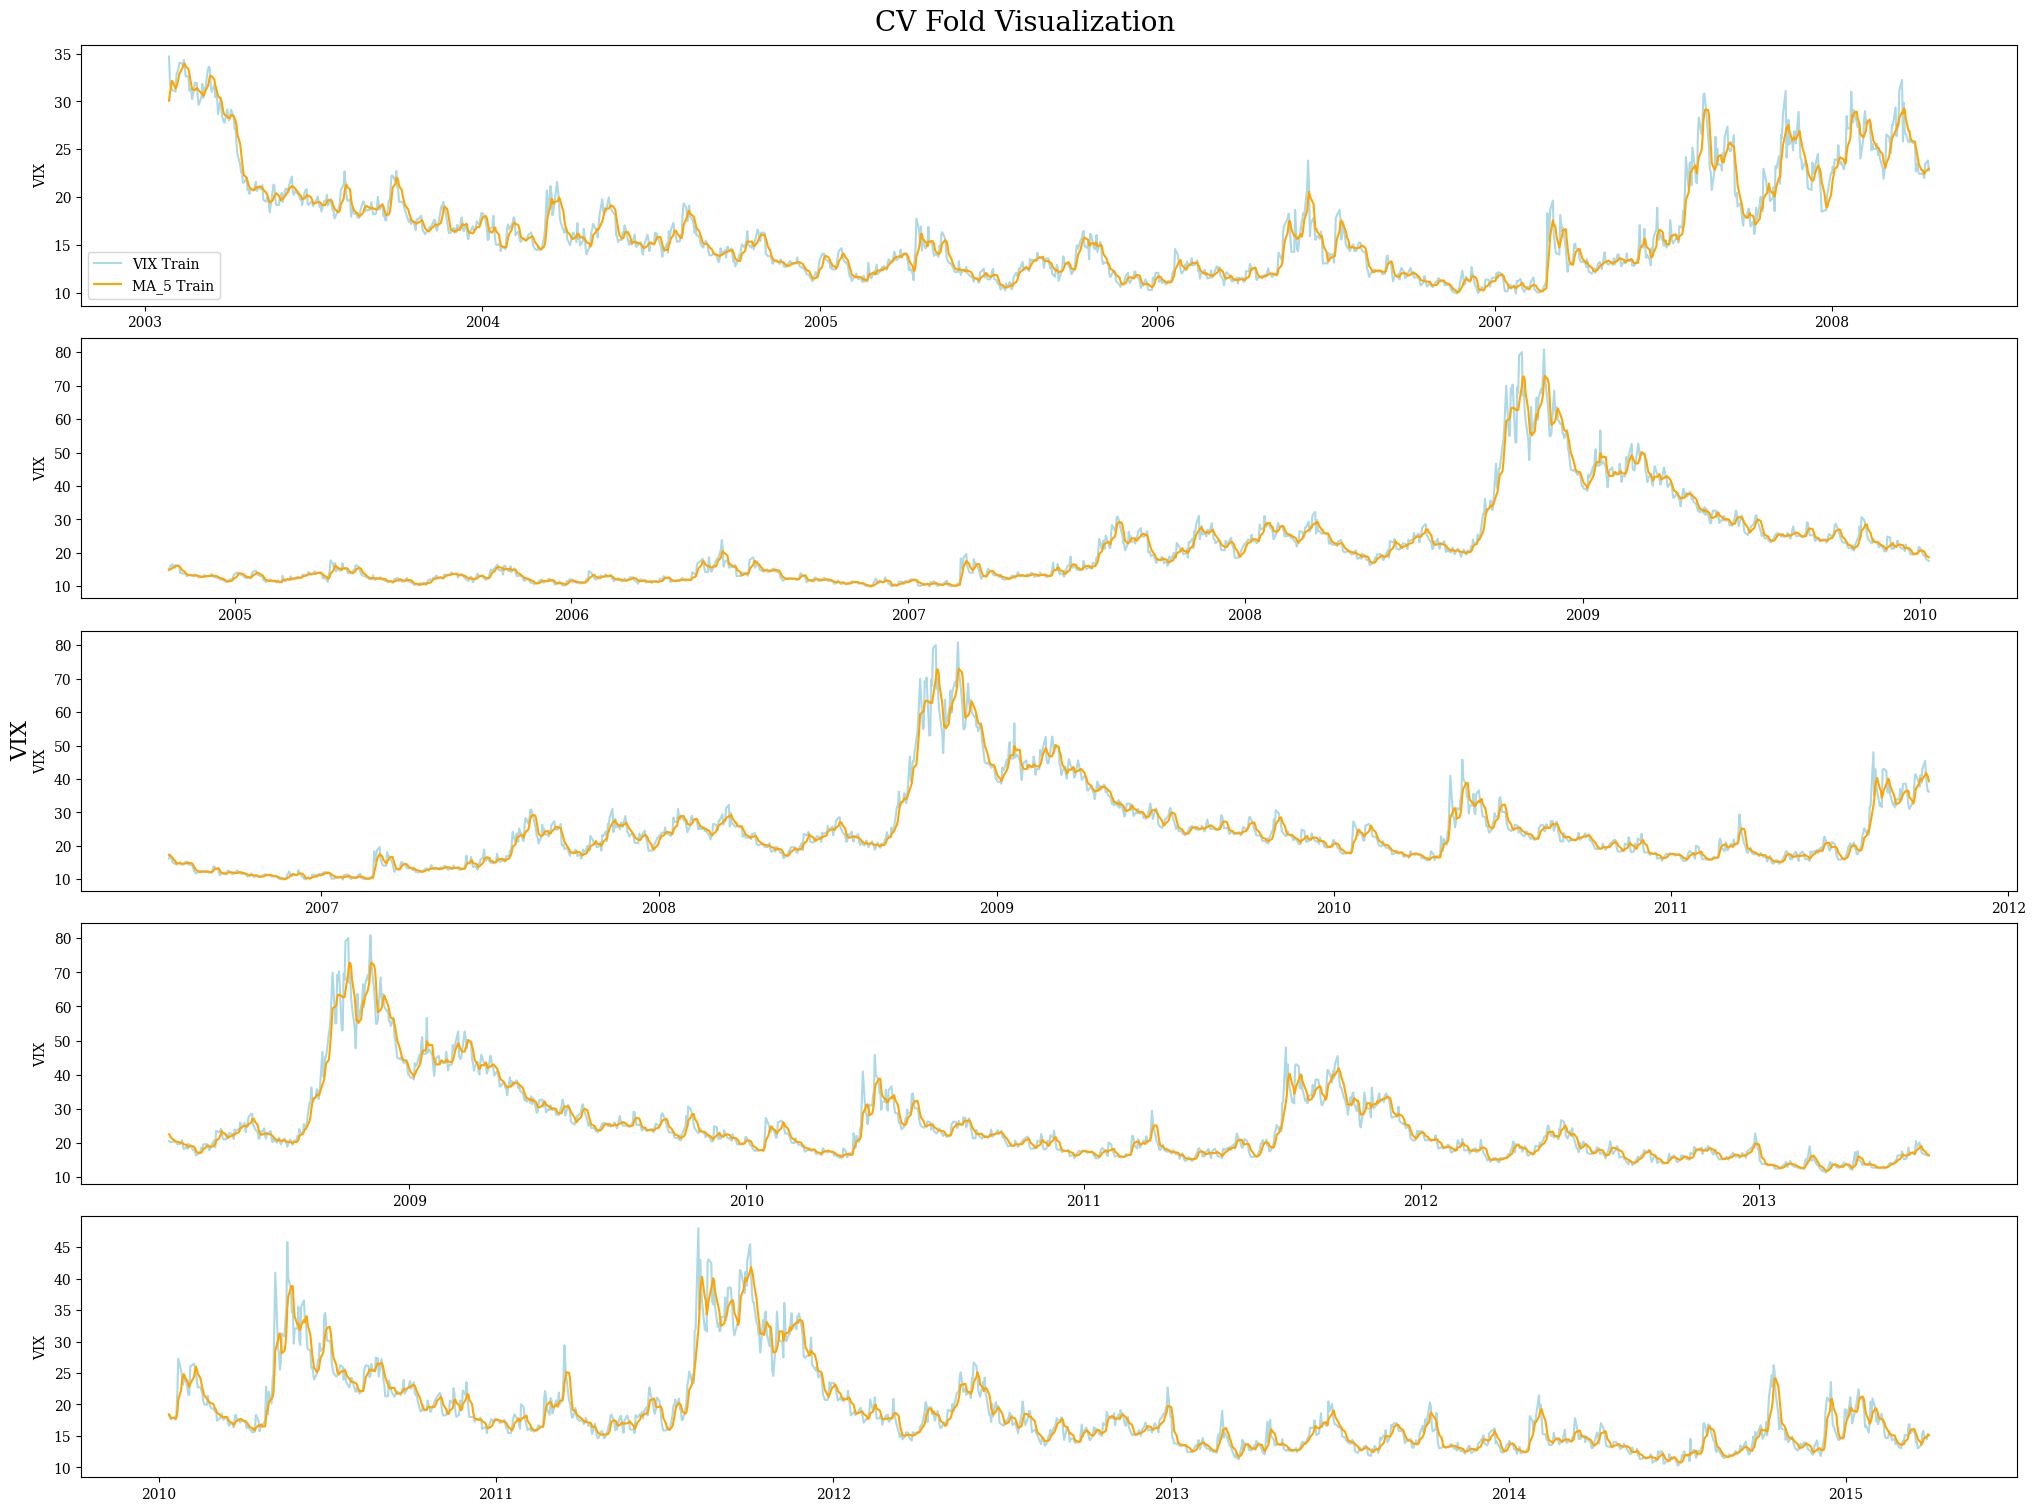

In [53]:
# Create splits
folds = split_data(
    x_train=x_train, y_train=y_train, n_splits=5, 
    train_splits=3, test_splits=1,

)
fig, axs = plt.subplots(5, figsize=(20, 15), constrained_layout=True)
i = 0
i_train = 0
i_test = 0
for fold, ax in zip(folds, axs.ravel()):
    #if i > 4:
    #    break
    train = train_df.iloc[fold[0]]
    test = train_df.iloc[fold[1]]
    palette={"VIX": "lightblue", "MA_5":"orange"}
    sns.lineplot(train["VIX"], color="lightblue", ax=ax, label="VIX Train")
    sns.lineplot(train["MA_5"], color="orange", ax=ax, label="MA_5 Train")
    m1 = df.index < train.index[0]
    m2 = df.index > test.index[-1]
    #sns.lineplot(df.loc[m1, "VIX"], color="lightgrey", ax=ax, ls=":")
    #sns.lineplot(df.loc[m2, "VIX"], color="lightgrey", ax=ax, ls=":")
    #ax.set_ylabel(None)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    i_train += len(train)
    if i > 0:
        ax.get_legend().remove()
    i += 1
fig.text(-0.01, 0.5, "VIX", rotation=90, fontsize=16)
fig.suptitle("CV Fold Visualization ", fontsize=20);

# SARIMA w/ expanding window and folds
The idea is to set the data within each fold as the traning data. Then, perform expanding window by adding one day at the time from the validation data, and refit model.

## Function for creating window data (not necessary for statsmodels)

In [188]:
def create_data(fold, train_df:pd.DataFrame, window_generator:WindowGenerator):
    # Get indices
    train_indices, val_indices = fold
    # Get data 
    train = train_df.iloc[train_indices]
    val = train_df.iloc[val_indices]
    # Scale fold
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    # Make dataset using Windowgenerator
    train = window_generator.make_dataset(train)
    val = window_generator.make_dataset(val)

    # Convert to numpy arrays
    train_X = np.concatenate([x for x, y in train], axis=0)
    train_X = train_X.reshape(len(train_X), -1)
    
    train_y = np.concatenate([y for x, y in train], axis=0)
    train_y = train_y.reshape((-1))

    val_X = np.concatenate([x for x, y in val], axis=0)
    val_X = val_X.reshape(len(val_X), -1)
    
    val_y = np.concatenate([y for x, y in val], axis=0)
    val_y = val_y.reshape((-1))
    
    return train_X, train_y, val_X, val_y

## Specify metrics

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [76]:
metrics = {
    "mse":mean_squared_error, "mae": mean_absolute_error, 
    "mape": mean_absolute_percentage_error, "r2":r2_score
}

## Create folds
Using the `size` params circumvents the need to create `X` and `y` array.

Use the default split size of 5 and 3:1 ratio

In [351]:
folds = list(split_data(x_train=None, y_train=None, size=len(train_df))) # Default: 5 splits, 3:1 ratio

## Perform cross-validation grid search

## Model search
For each fold, the model will be estimated on the training data within the fold. Then, it will produce a rolling forecast **WITHOUT** being reestimated for the validation data

In [234]:
from itertools import product

Specify parameters

In [297]:
param_grid  = dict(
    num_lags=[1,2,3,4,5],
    include_exo=[True, False]
)
# Get cross product of parameters as list
param_keys = param_grid.keys()
combinations = product(*param_grid.values())
ds = [dict(zip(param_keys, cc)) for cc in combinations]

Perform grid search

In [312]:
metrics.keys()

dict_keys(['mse', 'mae', 'mape', 'r2'])

In [451]:
iterables = [[str(d)[1:-1] for d in ds], ["mse", "mae", "mape", "r2"]]
idx = pd.MultiIndex.from_product(iterables, names=["hyperparameters", "scores"])
results = pd.DataFrame(
    index=range(1,6),
    columns=idx,
)
results.index.name = "Folds"

In [453]:
# Create list of cross product of values in dictionary

param_results = dict()
res_dict = dict()

for grid in ds:
    # TODO
    # Print current parameter specifications
    print(f"Params: {grid}")
    p = grid["num_lags"]
    include_exo = grid["include_exo"]
    name = str(grid)[1:-1]
    # Create result dictionary 
    for i, fold in enumerate(folds):
        print(f"In fold {i} ")
        train_indices, val_indices = fold
        # Get data 
        train = train_df.iloc[train_indices]
        val = train_df.iloc[val_indices]
        # Setup forecasts
        nforecasts = 1
        forecasts = {}

        # Get endogenous and exogenous data
        endog = train.VIX
        m = train.columns != "VIX"
        exog = train.loc[:, m] if include_exo else None

        # Create model using specified order p of AR process, and q of MA process
        mod_ar2 = sm.tsa.AutoReg(endog=endog, exog=exog, trend="n", lags=p)
        # Note that mod_ar2 is an instance of the SARIMAX class

        # Fit the model via maximum likelihood
        res = mod_ar2.fit()

        # Save initial forecast
        if include_exo:
            forecasts[endog.index[-1].date()] = res.forecast(steps=nforecasts, exog=exog.iloc[[-1]])
        else:
            forecasts[endog.index[-1].date()] = res.forecast(steps=nforecasts)


        # Iterate over validation data
        print("Forecasting")
        for index, data in val.iterrows():
            # Convert data to dataframe for ease of use
            dt = data.to_frame().T
            # Add new observation
            updated_endog = dt["VIX"].asfreq("B")
            updated_exog = dt.loc[:, dt.columns != "VIX"].asfreq("B")
            # Save new set of forecasts
            if include_exo:
                res = res.append(endog=updated_endog, exog=updated_exog, refit=False)
                forecasts[updated_endog.index[0].date()] = res.forecast(steps=nforecasts, exog=updated_exog)
            else:
                res = res.append(endog=updated_endog, refit=False)
                forecasts[updated_endog.index[0].date()] = res.forecast(steps=nforecasts)

        # Combine all forecasts into a dataframe
        forecasts = pd.concat(forecasts, axis=1)
        # Get forecasts as dataframe
        fc = pd.DataFrame(np.diag(forecasts), index=forecasts.index, columns=["Prediction"])
        # Combine forecasts with true values
        comb = fc.iloc[:-1].join(val.VIX)
        print("Saving results")
        # Compute and save metrics
        for key, metric in metrics.items():
            score = metric(comb.VIX, comb.Prediction)
            results.loc[i+1, (name, key)] = score
            
        # Save residual object
        res_key = name + f", 'fold': {i+1}"
        res_dict[res_key] = res
        print()
    print("-"*20)

Params: {'num_lags': 1, 'include_exo': True}
In fold 0 
Forecasting
Saving results

In fold 1 
Forecasting
Saving results

In fold 2 
Forecasting
Saving results

In fold 3 
Forecasting
Saving results

In fold 4 
Forecasting
Saving results

--------------------
Params: {'num_lags': 1, 'include_exo': False}
In fold 0 
Forecasting
Saving results

In fold 1 
Forecasting
Saving results

In fold 2 
Forecasting
Saving results

In fold 3 
Forecasting
Saving results

In fold 4 
Forecasting
Saving results

--------------------
Params: {'num_lags': 2, 'include_exo': True}
In fold 0 
Forecasting
Saving results

In fold 1 
Forecasting
Saving results

In fold 2 
Forecasting
Saving results

In fold 3 
Forecasting
Saving results

In fold 4 
Forecasting
Saving results

--------------------
Params: {'num_lags': 2, 'include_exo': False}
In fold 0 
Forecasting
Saving results

In fold 1 
Forecasting
Saving results

In fold 2 
Forecasting
Saving results

In fold 3 
Forecasting
Saving results

In fold 4 
For

## Display results

### Overall

In [454]:
results.T

Folds                                               1          2         3  \
hyperparameters                     scores                                   
'num_lags': 1, 'include_exo': True  mse      9.188282   5.494926  2.022279   
                                    mae      1.895518   1.468739  1.017683   
                                    mape     0.051519   0.058415  0.054759   
                                    r2       0.952409   0.884065  0.923119   
'num_lags': 1, 'include_exo': False mse      8.812887    4.98185  1.848232   
                                    mae      1.745434   1.317921  0.911171   
                                    mape     0.047193   0.052269  0.047914   
                                    r2       0.954354    0.89489  0.929735   
'num_lags': 2, 'include_exo': True  mse       9.40926   5.842485  2.073515   
                                    mae       1.93684   1.516637  1.043142   
                                    mape     0.053003    0.06027  0.056231   
                                    r2       0.951265   0.876732  0.921171   
'num_lags': 2, 'include_exo': False mse      8.672085   4.852642  1.795485   
                                    mae      1.753217   1.332715  0.906253   
                                    mape     0.047396   0.052839  0.047654   
                                    r2       0.955083   0.897616  0.931741   
'num_lags': 3, 'include_exo': True  mse      9.653078   5.715202  2.021764   
                                    mae      1.979702   1.517712  1.039891   
                                    mape     0.053985   0.060625  0.055912   
                                    r2       0.950002   0.879418  0.923138   
'num_lags': 3, 'include_exo': False mse      8.436628   5.069702   1.77901   
                                    mae      1.747155   1.354064  0.908522   
                                    mape     0.047409    0.05349  0.047839   
                                    r2       0.956302   0.893037  0.932367   
'num_lags': 4, 'include_exo': True  mse       9.62362   5.916135  2.051346   
                                    mae      2.001153   1.544568  1.044987   
                                    mape     0.054802   0.061788  0.056172   
                                    r2       0.950154   0.875178  0.922014   
'num_lags': 4, 'include_exo': False mse      8.444769   5.071057  1.763008   
                                    mae      1.747352   1.354115  0.912953   
                                    mape     0.047402    0.05349  0.048121   
                                    r2        0.95626   0.893008  0.932975   
'num_lags': 5, 'include_exo': True  mse     16.242502  10.872587  4.081355   
                                    mae      2.465626   2.036967  1.403275   
                                    mape     0.067632   0.080795  0.075353   
                                    r2       0.915872   0.770605  0.844839   
'num_lags': 5, 'include_exo': False mse      8.368686   5.127281   1.76256   
                                    mae      1.740615   1.347568  0.914857   
                                    mape     0.047242   0.053214  0.048362   
                                    r2       0.956654   0.891822  0.932993   

Folds                                              4         5  
hyperparameters                     scores                      
'num_lags': 1, 'include_exo': True  mse     1.392848  3.072705  
                                    mae     0.855439  1.127596  
                                    mape    0.056727  0.064844  
                                    r2      0.777762   0.84171  
'num_lags': 1, 'include_exo': False mse     1.204333  2.617672  
                                    mae     0.754188  1.030043  
                                    mape    0.048893  0.058572  
                                    r2       0.80784  0.865151  
'num_lags': 2, 'include_exo': True  mse     1.604543  3.338118  
        

In [455]:
scores = results.columns.get_level_values(1).unique()

### Per scoring method

In [456]:
best_cols = []
for score in scores:
    print(f"Score: {score}")
    if score != "r2":
        min_cols = results.xs(score, axis=1, level="scores").astype(np.float32).idxmin(axis=1)
    else:
        min_cols = results.xs(score, axis=1, level="scores").astype(np.float32).idxmax(axis=1)
    best_cols.extend(min_cols.unique())
    print(f"More than one set of hyperparameters: {len(min_cols.unique()) > 1}")
    display(results.loc[:, (min_cols, score)])
    print("-"*40)

Score: mse
More than one set of hyperparameters: True


hyperparameters,"'num_lags': 5, 'include_exo': False","'num_lags': 2, 'include_exo': False","'num_lags': 1, 'include_exo': False"
scores,mse,mse,mse
Folds,,,
1,8.368686,8.672085,8.812887
2,5.127281,4.852642,4.98185
3,1.76256,1.795485,1.848232
4,1.243968,1.215953,1.204333
5,2.696695,2.714493,2.617672


----------------------------------------
Score: mae
More than one set of hyperparameters: True


hyperparameters,"'num_lags': 5, 'include_exo': False","'num_lags': 1, 'include_exo': False","'num_lags': 2, 'include_exo': False"
scores,mae,mae,mae
Folds,,,
1,1.740615,1.745434,1.753217
2,1.347568,1.317921,1.332715
3,0.914857,0.911171,0.906253
4,0.764154,0.754188,0.756547
5,1.041306,1.030043,1.037629


----------------------------------------
Score: mape
More than one set of hyperparameters: True


hyperparameters,"'num_lags': 1, 'include_exo': False","'num_lags': 2, 'include_exo': False"
scores,mape,mape
Folds,,
1,0.047193,0.047396
2,0.052269,0.052839
3,0.047914,0.047654
4,0.048893,0.049073
5,0.058572,0.059051


----------------------------------------
Score: r2
More than one set of hyperparameters: True


hyperparameters,"'num_lags': 5, 'include_exo': False","'num_lags': 2, 'include_exo': False","'num_lags': 1, 'include_exo': False"
scores,r2,r2,r2
Folds,,,
1,0.956654,0.955083,0.954354
2,0.891822,0.897616,0.89489
3,0.932993,0.931741,0.929735
4,0.801516,0.805986,0.80784
5,0.86108,0.860163,0.865151


----------------------------------------


### Compared

In [457]:
best_cols = np.unique(np.array(best_cols))
# Swap the levels to get better comparison against set of hyperparams
results.swaplevel(axis=1).loc[:, (("mse", "mae", "mape", "r2"), best_cols)]

scores                                          mse  \
hyperparameters 'num_lags': 1, 'include_exo': False   
Folds                                                 
1                                          8.812887   
2                                           4.98185   
3                                          1.848232   
4                                          1.204333   
5                                          2.617672   

scores                                               \
hyperparameters 'num_lags': 2, 'include_exo': False   
Folds                                                 
1                                          8.672085   
2                                          4.852642   
3                                          1.795485   
4                                          1.215953   
5                                          2.714493   

scores                                               \
hyperparameters 'num_lags': 5, 'include_exo': False   
Folds                                                 
1                                          8.368686   
2                                          5.127281   
3                                           1.76256   
4                                          1.243968   
5                                          2.696695   

scores                                          mae  \
hyperparameters 'num_lags': 1, 'include_exo': False   
Folds                                                 
1                                          1.745434   
2                                          1.317921   
3                                          0.911171   
4                                          0.754188   
5                                          1.030043   

scores                                               \
hyperparameters 'num_lags': 2, 'include_exo': False   
Folds                                                 
1                                          1.753217   
2                                          1.332715   
3                                          0.906253   
4                                          0.756547   
5                                          1.037629   

scores                                               \
hyperparameters 'num_lags': 5, 'include_exo': False   
Folds                                                 
1                                          1.740615   
2                                          1.347568   
3                                          0.914857   
4                                          0.764154   
5                                          1.041306   

scores                                         mape  \
hyperparameters 'num_lags': 1, 'include_exo': False   
Folds                                                 
1                                          0.047193   
2                                          0.052269   
3                                          0.047914   
4                                          0.048893   
5                                          0.058572   

scores                                               \
hyperparameters 'num_lags': 2, 'include_exo': False   
Folds                                                 
1                                          0.047396   
2                                          0.052839   
3                                          0.047654   
4                                          0.049073   
5                                          0.059051   

scores                                               \
hyperparameters 'num_lags': 5, 'include_exo': False   
Folds                                                 
1                                          0.047242   
2                                          0.053214   
3                                          0.048362   
4                                          0.049537   
5                                           0.05952   

scores                         

## Save results

### Results dataframe

In [458]:
results.to_csv("../data/arx_crossval_results.csv")

To read file:
```Python
pd.read_csv("../data/arx_crossval_results.csv", index_col=0, header=[0, 1])
```

### Residual objects
Save all residuals

In [476]:
import os

In [ ]:
import pickle
fname = os.getcwd() + "/residuals"
with open(fname, 'wb') as handle:
    pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


To read data:
```Python
with open("residuals", 'rb') as f:
    m = pickle.load(f)
```

# Some diagnostic checks

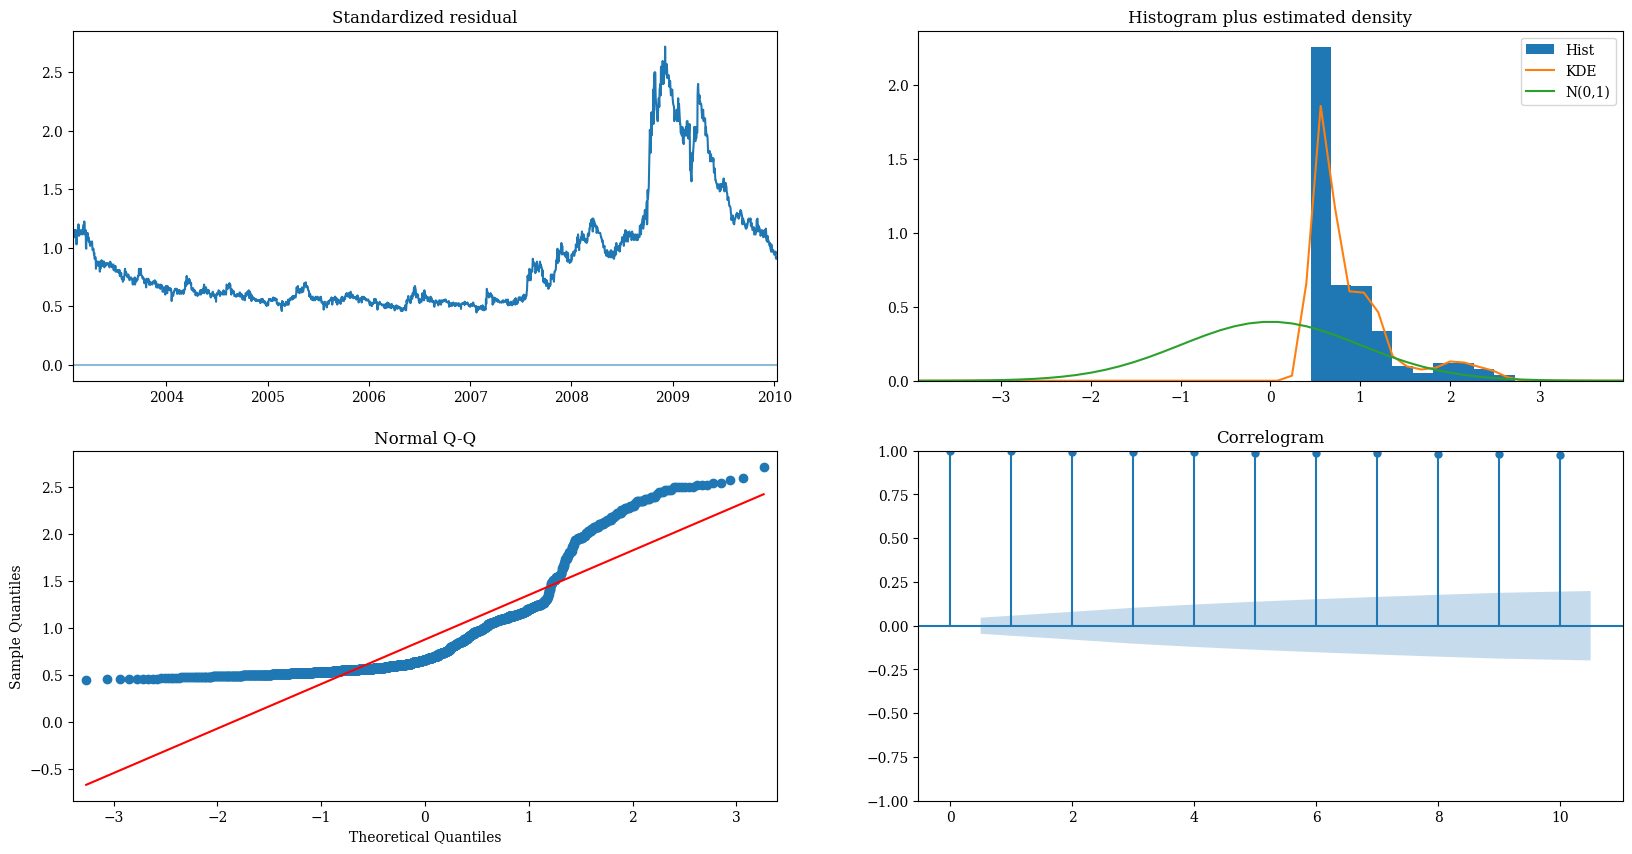

In [224]:
fig = plt.figure(figsize=(20, 10))
res.plot_diagnostics(fig=fig);